## Import Required Libraries
Running cell below will import the required libraries being used in the rest of the cells of this notebook

In [1]:
import cv2
import json
import numpy as np
import sys, os, importlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn.functional as F
from torchvision import transforms
from scipy.ndimage import gaussian_filter
from skimage.filters import gaussian

from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble='\\usepackage{color}')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import shap_bpt as shap_bpt
print('shap_bpt version:',shap_bpt.__version__)

shap_bpt version: 1.0


## GPU configuration if available

In [3]:
use_cuda = torch.cuda.is_available()
use_mps = ('mps' in dir(torch.backends)) and torch.backends.mps.is_available()
torch.manual_seed(12345)

if use_cuda:    device = torch.device("cuda")
elif use_mps:   device = torch.device("mps")
else:           device = torch.device("cpu")
print('device:', device)

device: cuda


In [4]:
def np_softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

## BlackBox model

In [5]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
model.eval()

# # SWIN-ViT from timm
# from torchvision.models import swin_t
# model = swin_t(weights='IMAGENET1K_V1').to(device)
# model.eval()

# from torchvision.models import vgg16
# model = vgg16(weights='IMAGENET1K_V1').to(device)
# model.eval()

# ResNet50 preprocessing
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
resnet50_preprocess = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)
resnet50_normalize = transforms.Normalize(mean=mean, std=std)
def f(x):
    with torch.no_grad():
        # return F.softmax(model(x), dim=1).cpu().detach().numpy()
        return model(x).cpu().detach().numpy()

In [6]:
os.makedirs('paper_figures',exist_ok=True)

## Load image and groundtruth

In [13]:
path_base = os.getcwd()
path_utils = os.path.join(path_base, 'notebooks/utils')
path_ds = os.path.join(path_base, 'notebooks/datasets/imgs')

with open(f'{path_utils}/imagenet_class_index.json') as file:
    class_names = [v[1] for v in json.load(file).values()]

# Foreground image to be explained
path_img = f'{path_ds}/flamingo4.png'
if os.path.exists(path_img):
    image_to_explain = cv2.resize(cv2.imread(path_img, cv2.IMREAD_COLOR),[224,224])[:,:,::-1]#.astype(np.float32)
    image_to_explain_preproc = resnet50_preprocess(image_to_explain.astype(np.float32)/255.0)
    image_to_explain_tensor = image_to_explain_preproc.to(device)
    ground_truth = cv2.imread(f'{path_ds}/flamingo4_gt.png', cv2.IMREAD_GRAYSCALE) != 0
    # Background (random Gaussian noise)
    np.random.seed(0)

    print(image_to_explain.shape, image_to_explain.dtype)
else:
    print('image not found -->', path_img)
    # raise 'Image Not found'

(224, 224, 3) uint8


In [14]:
bkgnd0 = np.full_like(image_to_explain, 0)
bkgnd1 = np.full_like(image_to_explain, 127)
bkgnd2 = np.full_like(image_to_explain, 255)
bkgnd3 = gaussian(image_to_explain, 8, channel_axis=-1)*255
bkgnd4 = np.clip(np.random.normal(128, 128, size=image_to_explain.shape), 0, 255).astype(np.uint8)
bkgnd4 = (gaussian(bkgnd4, 2.0, channel_axis=-1) * 255).astype(np.uint8)

background_image_set = np.array([
    bkgnd0, 
    bkgnd1, 
    bkgnd2, 
    bkgnd3, 
    bkgnd4
])

background_tensors = torch.cat([torch.unsqueeze(resnet50_preprocess(bkgnd.astype(np.float32)/255.0), dim=0) 
                                for bkgnd in background_image_set]).to(device)

def f_masked(masks):
    global f, background_tensors, image_to_explain_tensor
    N,H,W = masks.shape
    B = background_tensors.shape[0]
    masks_tensor = torch.tensor(np.array(masks)).to(device) # N boolean masks with size W*H
    masks_tensor = torch.reshape(masks_tensor, (N,1,H,W)) # N*H*W -> N*1*H*W
    masks_tensor = torch.tile(masks_tensor, dims=(1,3,B,1)).reshape(B*N,3,H,W) # N*1*H*W -> NB*3*H*W
    
    Xf = torch.tile(image_to_explain_tensor, dims=(N*B,1,1,1)) # 3*H*W -> NB*3*H*W
    Xb = torch.tile(background_tensors, dims=(N,1,1,1)) # 3*H*W -> NB*3*H*W
    X = torch.where(masks_tensor, Xf, Xb) # T=Xf, F=Xb
    result = f(X)
    del X, Xb, Xf, masks_tensor
    result = result.reshape((-1, B, result.shape[1]))
    return np.mean(result, axis=1)


predicted_fS = f_masked(np.ones([1,image_to_explain.shape[0],image_to_explain.shape[1]], dtype=bool))[0]
sorted_classes = np.flip(np.argsort(predicted_fS))
predicted_cls = sorted_classes[0]
f_S = float(predicted_fS[predicted_cls])
predicted_f0 = f_masked(np.zeros([1,image_to_explain.shape[0],image_to_explain.shape[1]], dtype=bool))[0]
f_0 = float(predicted_f0[predicted_cls])
print(class_names[predicted_cls], f_S, predicted_cls, f_0)
print('softmax prob:', np_softmax(predicted_fS)[predicted_cls])


flamingo 6.936495780944824 130 0.48218125104904175
softmax prob: 0.5051146


## Image with Background Replacement Strategy for Masking Function

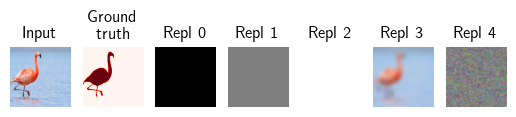

In [15]:
fig,ax = plt.subplots(1,2+len(background_image_set))
ax[0].imshow(image_to_explain)
ax[0].set_title('Input')
ax[0].set_axis_off()
ax[1].imshow(ground_truth, cmap='Reds')
ax[1].set_title('Ground\ntruth')
ax[1].set_axis_off()
for i,img in enumerate(background_image_set):
    ax[i+2].imshow(img.astype(np.uint8))
    ax[i+2].set_title(f'Repl {i}')
    ax[i+2].set_axis_off()
plt.show()

In [16]:
# evaluate the ground truth mask with the background replacement strategy for masking function
predicted_fG = f_masked(np.expand_dims(ground_truth, axis=0))[0]
f_G = float(predicted_fG[predicted_cls])
print(class_names[predicted_cls], f_G, predicted_cls, f_G)
print('softmax prob:', np_softmax(predicted_fG)[predicted_cls])

# evaluate the backgrounf (negative of the ground truth mask)
background_mask = np.logical_not(ground_truth)
predicted_fB = f_masked(np.expand_dims(background_mask, axis=0))[0]
f_B = float(predicted_fB[predicted_cls])
print(class_names[predicted_cls], f_B, predicted_cls, f_B)
print('softmax prob:', np_softmax(predicted_fB)[predicted_cls])

print()
print('nu(S):', round(f_S, 4))
print('nu(G):', round(f_G, 4))
print('nu(B):', round(f_B, 4))
print('nu(0):', round(f_0, 4))

flamingo 6.8895978927612305 130 6.8895978927612305
softmax prob: 0.4943533
flamingo 4.239899635314941 130 4.239899635314941
softmax prob: 0.04495299

nu(S): 6.9365
nu(G): 6.8896
nu(B): 4.2399
nu(0): 0.4822


# BPT

In [17]:
# how many black-box model evaluations f() we are willing to pay to get an Owen-explanation
MAX_EVALS_BUDGET      = 100
batch_size            = 4
num_explained_classes = 4
max_weight            = None
# 1/4 -> 10 reaches 16 terminals
# 1/16 -> 170 reaches 256 terminals
# 1/64 -> 2730 reaches 4096 terminals
# 1/256 -> 43690 reaches 65536 terminals

In [18]:
explainer = shap_bpt.Explainer(f_masked, image_to_explain, num_explained_classes=num_explained_classes, verbose=True)
shap_values_bpt = explainer.explain_instance(MAX_EVALS_BUDGET, method='BPT',
                                             batch_size=batch_size, max_weight=max_weight)

  0%|          | 0/100 [00:00<?, ?it/s]

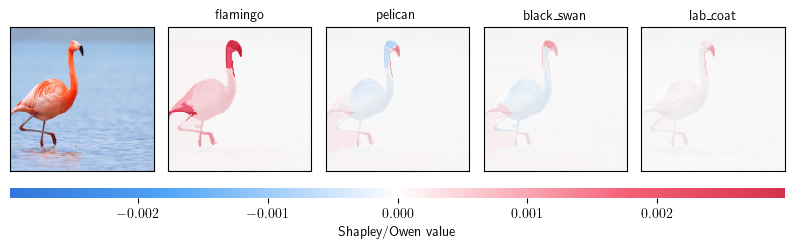

In [26]:
shap_bpt.plot_owen_values(explainer, shap_values_bpt, class_names)
# shap_bpt.plot_shapley_values(explainer, shap_values_bpt, class_names=class_names, show_nu_values=True)

In [27]:
print('Expected Shapley explanation: ', explainer.base_f_S[0] - explainer.base_f_0[0])
print('Computed Shapley explanation: ', np.sum(shap_values_bpt[0]))

Expected Shapley explanation:  6.4543145298957825
Computed Shapley explanation:  6.454314529895783


# Axis-Aligned

In [28]:
explainer = shap_bpt.Explainer(f_masked, image_to_explain, num_explained_classes=num_explained_classes, verbose=True)
shap_values_aa = explainer.explain_instance(MAX_EVALS_BUDGET, method='AA', verbose_plot=False, 
                                            batch_size=batch_size, max_weight=max_weight)

  0%|          | 0/100 [00:00<?, ?it/s]

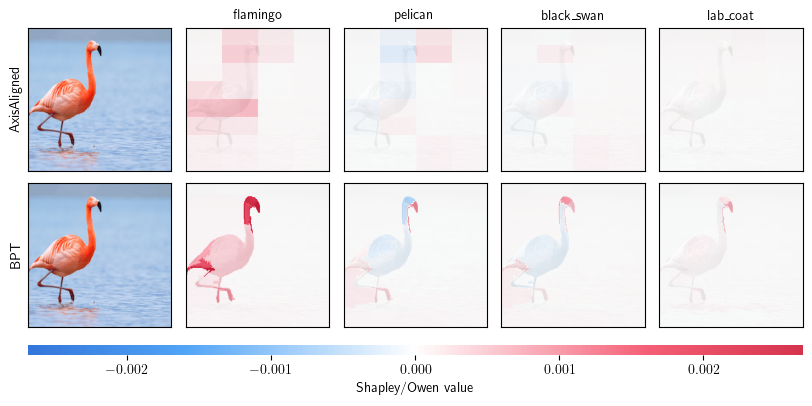

In [30]:
shap_bpt.plot_owen_values(explainer, [shap_values_aa,shap_values_bpt], 
                          class_names, names=['AxisAligned','BPT'])

In [31]:
print('Expected Shapley explanation: ', explainer.base_f_S[0] - explainer.base_f_0[0])
print('Computed Shapley explanation: ', np.sum(shap_values_aa[0]))

Expected Shapley explanation:  6.4543145298957825
Computed Shapley explanation:  6.454314529895783


In [32]:
# os.makedirs('saved_explanations',exist_ok=True)
# for MAX_EVALS_BUDGET, max_weight in [(1000, 1/16), (10, None), (100, None), (500, None), (1000, None)]:
#     print(MAX_EVALS_BUDGET, max_weight)
#     explainer = shap_bpt.Explainer(f_masked, image_to_explain, num_explained_classes=num_explained_classes, verbose=True)
#     bptree = shap_bpt.build_bpt_from_image(image_to_explain)#, use_sqrt_area=False)
#     shap_values_bpt = explainer.explain_instance(MAX_EVALS_BUDGET, method='BPT', bpt=bptree, verbose_plot=False, 
#                                                  batch_size=batch_size, max_weight=max_weight)
#     shap_values_aa = explainer.explain_instance(MAX_EVALS_BUDGET, method='AA', verbose_plot=False, 
#                                                 batch_size=batch_size, max_weight=max_weight)
#     shap_bpt.plot_owen_values(explainer, [shap_values_aa,shap_values_bpt], 
#                               class_names, names=['AxisAligned','BPT'])
    
#     wn = str(round(1/max_weight)) if max_weight is not None else 'None'
#     np.savetxt(f'saved_explanations/shapley0bpt_{wn}_{MAX_EVALS_BUDGET}.txt', shap_values_bpt[0])
#     np.savetxt(f'saved_explanations/shapley0aa_{wn}_{MAX_EVALS_BUDGET}.txt', shap_values_aa[0])

In [33]:
# h = shap_values_bpt[0]
# vmax = np.max(np.abs(h))
# fig,axes = plt.subplots(1,4, figsize=(10,3))
# for i, cm in enumerate([shap_bpt.shapley_values_colormap, 'seismic', 'bwr', 'coolwarm']):
#     axes[i].imshow(h, cmap=cm, vmin=-vmax, vmax=vmax)

# Loading and showing the computed explanations

In [34]:
suffix_lst = ['None_10', 'None_100', 'None_500', 'None_1000']

shapley_aa = dict()
shapley_bpt = dict()
vmax = 0.0
for sfx in suffix_lst:
    shapley_aa[sfx] = np.loadtxt(f'saved_explanations/shapley0aa_{sfx}.txt')
    shapley_bpt[sfx] = np.loadtxt(f'saved_explanations/shapley0bpt_{sfx}.txt')
    vmax = max(vmax, np.max(np.abs(shapley_aa[sfx])))
    vmax = max(vmax, np.max(np.abs(shapley_bpt[sfx])))
    
print(vmax)

0.005955302532460091


### FIGURE 3: A (AA & BPT)

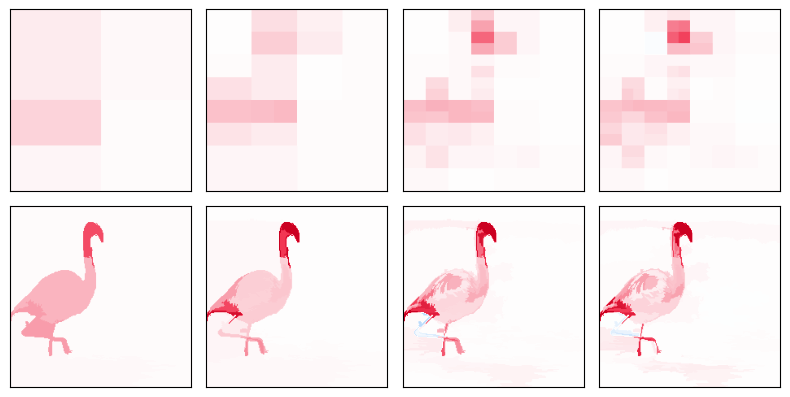

In [35]:
# vmax = 0.00022
vmax = 0.003
fig,ax = plt.subplots(2,len(suffix_lst), figsize=(len(suffix_lst)*2, 4.2))
for i,w in enumerate(suffix_lst):
    ax[0,i].imshow(shapley_aa[w], cmap=shap_bpt.shapley_values_colormap, vmin=-vmax, vmax=vmax)
    ax[1,i].imshow(shapley_bpt[w], cmap=shap_bpt.shapley_values_colormap, vmin=-vmax, vmax=vmax)
    for k in range(2):
        ax[k,i].set_xticks([]) ; ax[k,i].set_yticks([])
plt.tight_layout()
plt.savefig(f'paper_figures/figure_2_aa_bpt_saliencies.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

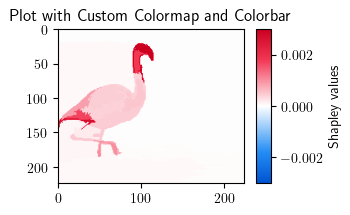

In [36]:
plt.figure(figsize=(3,2))
plt.imshow(shap_values_bpt[0], cmap=shap_bpt.shapley_values_colormap, aspect='auto', vmin=-vmax, vmax=vmax)
plt.colorbar(label='Shapley values', aspect=10)
plt.title('Plot with Custom Colormap and Colorbar')
plt.savefig(f'colorbar.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

## Figure 1:A

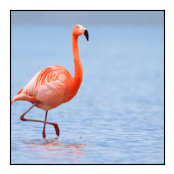

In [37]:
plt.figure(figsize=(2,2))
plt.imshow(image_to_explain); plt.xticks([]); plt.yticks([])
plt.savefig(f'paper_figures/figure_1_A.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

## Figure 1:B(AA & BPT)

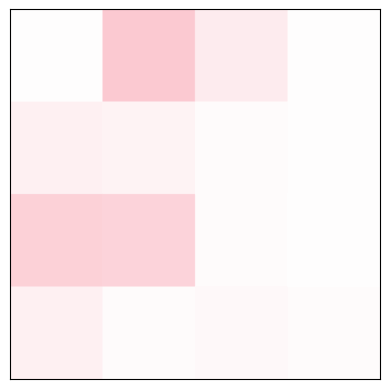

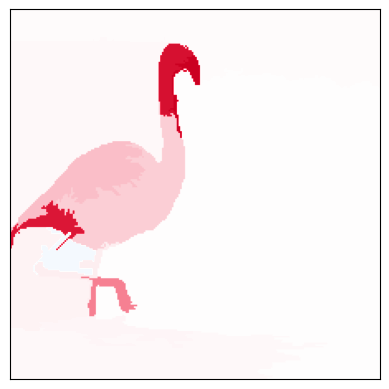

In [38]:
for name, img in [('aa4', np.loadtxt(f'saved_explanations/shapley0aa_16_1000.txt')), 
                  ('bpt4', np.loadtxt(f'saved_explanations/shapley0bpt_16_1000.txt'))]:
    plt.figure()
    plt.imshow(img, cmap=shap_bpt.shapley_values_colormap, vmin=-vmax, vmax=vmax)
    plt.xticks([]) ; plt.yticks([])
    plt.savefig(f'paper_figures/figure_1_B_{name}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
    plt.show()

# Evaluation

In [39]:
def saliency_to_auc(nu, heatmap, f_S, f_0, predicted_cls, batch_size=4, method='del', num_samples=101, 
                    rule='trapezoid'):
    assert isinstance(heatmap, np.ndarray)
    assert len(heatmap.shape)==2 and np.issubdtype(heatmap.dtype, np.floating)

    # nu_max = max(f_S, f_0)
    # nu_min = min(f_S, f_0)

    xs, ys, ms, masks, qs = [], [], [], [], []
    for i, value in enumerate(np.linspace(start=1.0, stop=0.0, num=num_samples)):
        if method=='del':
            epsilon = (1 if value==0.0 else 0)
            q = (np.quantile(heatmap, q=value) - epsilon)
            m = heatmap <= q
            nx = (1.0 - np.sum(m) / m.size)
        elif method=='ins':
            epsilon = (1 if value==1.0 else 0)
            q = (np.quantile(heatmap, q=value) + epsilon)
            m = heatmap >= q
            nx = (np.sum(m) / m.size)
        else:
            raise Exception()
            
        # add a new datapoint on the curve
        if len(xs)==0 or nx != xs[-1]: 
            assert m.dtype==bool and len(m.shape)==2
            xs.append(nx)
            masks.append(m)
            ms.append(np.sum(heatmap[m]))
            qs.append(q)

        # evaluate the characteristic function
        if len(masks) >= batch_size or (len(masks)>0 and i==(num_samples-1)):
            y = nu(np.array(masks))[:, predicted_cls]
            ys.extend(y)
            masks = []

    assert len(masks)==0    
    xs, ys = np.array(xs), np.array(ys)
    assert(len(xs) == len(ys))

    # compute considering under/over shoots
    if f_S > f_0:
        overshoot_max = np.maximum(0, ys - f_S) # overshoot for values exceeding the maximum f(S)
        overshoot_min = np.maximum(0, f_0 - ys) # overshoot for values below the minimum f(0)
    else: # f(S) < f(0)
        overshoot_max = np.maximum(0, ys - f_0) # overshoot for values exceeding the maximum f(0)
        overshoot_min = np.maximum(0, f_S - ys) # overshoot for values below the minimum f(S)

    # clip ys, no oveshoots
    y_clipped = np.clip(ys, min(f_S, f_0), max(f_S, f_0))
    # adjust ys with the overshoot. Clip it inside the admitted range
    y_adjusted = np.clip(ys - 2*overshoot_max + 2*overshoot_min, min(f_S, f_0), max(f_S, f_0))

    # rebase to f(0)
    if f_S > f_0:
        flipped = False
        ys = ys - f_0 
        y_clipped = y_clipped - f_0 
        y_adjusted = y_adjusted - f_0
    else: # f(S) < f(0)
        flipped = True
        ys = f_0 - ys 
        y_clipped = f_0 - y_clipped 
        y_adjusted = f_0 - y_adjusted

    # rescaling
    ys_rescaled = ys / abs(f_S - f_0)
    y_clipped_rescaled = y_clipped / abs(f_S - f_0)
    y_adjusted_rescaled = y_adjusted / abs(f_S - f_0)

    auc, auc_r, auc_mae, auc_mse, auc_adj, auc_adjr, auc_clip, auc_clipr = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    curve_range = range(1, len(xs)) if rule=='trapezoid' else range(len(xs))

    # compute the area under the curve with the midpoint Riemann sum (i.e. the trapezoidal rule)
    for i in curve_range:
        if rule=='trapezoid':
            delta_x = abs(xs[i] - xs[i-1])
            assert delta_x > 0
            y_mid   =         0.5*(ys[i-1] + ys[i])
            y_r_mid =         0.5*(ys_rescaled[i-1] + ys_rescaled[i])
            err_mid = y_mid - 0.5*(ms[i-1] - ms[i])
            y_clip_mid =       0.5*(y_clipped[i-1] + y_clipped[i])
            y_clipr_mid =      0.5*(y_clipped_rescaled[i-1] + y_clipped_rescaled[i])
            y_adj_mid =       0.5*(y_adjusted[i-1] + y_adjusted[i])
            y_adjr_mid =      0.5*(y_adjusted_rescaled[i-1] + y_adjusted_rescaled[i])
        else: # rectangles
            delta_x = 1.0/num_samples if i==len(xs)-1 else abs(xs[i+1] - xs[i])
            assert delta_x > 0
            y_mid   =         ys[i]
            y_r_mid =         ys_rescaled[i]
            err_mid = y_mid - ms[i]
            y_clip_mid =       y_clipped[i]
            y_clipr_mid =      y_clipped_rescaled[i]
            y_adj_mid =       y_adjusted[i]
            y_adjr_mid =      y_adjusted_rescaled[i]


        auc += abs(delta_x * y_mid) # base * height
        auc_r += abs(delta_x * y_r_mid) # base * height
        # auc_eff += abs(delta_x * err_mid) # base * height
        auc_mae += abs(delta_x * err_mid) # base * height
        auc_mse += abs(delta_x * (err_mid**2)) # base * height^2
        auc_clip += abs(delta_x * y_clip_mid)
        auc_clipr += abs(delta_x * y_clipr_mid)
        auc_adj += abs(delta_x * y_adj_mid)
        auc_adjr += abs(delta_x * y_adjr_mid)

    return {'xs':xs, 'ms':ms, 'qs':qs, 
            'f_0':f_0, 'f_S':f_S, 'flipped':flipped, 
            'ys':ys, 'ysr':ys_rescaled,
            'y_clip':y_clipped, 'y_clipr':y_clipped_rescaled, 
            'y_adj':y_adjusted, 'y_adjr':y_adjusted_rescaled, 
            'method':method, 'predicted_cls':predicted_cls,
            'auc':auc, 'auc_r':auc_r,
            'auc_mae':auc_mae, 'auc_mse':auc_mse, 'auc_rmse':np.sqrt(auc_mse), 
            'auc_clip':auc_clip, 'auc_clipr':auc_clipr,
            'auc_adj':auc_adj, 'auc_adjr':auc_adjr}

In [40]:
# def calc_IoU_curve(y_true, y_pred):
#     assert len(y_true.shape)==1 and len(y_pred.shape)==1 # assumes y_true and y_pred to be flattened arrays
#     yd = np.array(sorted(zip(y_pred, y_true), reverse=True))
#     X2   = np.zeros(len(y_pred))
#     IoU2 = np.zeros(len(y_pred))
#     Th   = np.zeros(len(y_pred))
    
#     nT = np.sum(y_true)
#     nInt = 0
#     for i in range(len(y_pred)):
#         if yd[i,1]: 
#             nInt += 1
        
#         IoU2[i] = nInt / (i + nT - nInt)
#         X2[i] = i
#         Th[i] = yd[i,0]
        
#     X2 = X2 / len(y_pred)
#     auc_IoU = 0
#     for i in range(1, len(y_pred)):
#         auc_IoU += (X2[i] - X2[i-1]) * (IoU2[i] + IoU2[i-1]) / 2.0
    
#     best_pt = np.argmax(IoU2)
#     return X2, IoU2, Th[best_pt], X2[best_pt], auc_IoU

def calc_IoU_curve(y_true, y_pred):
    assert isinstance(y_true, np.ndarray)
    assert isinstance(y_pred, np.ndarray)
    assert len(y_true.shape)==1 and len(y_pred.shape)==1 # assumes y_true and y_pred to be flattened arrays
    assert len(y_true)==len(y_pred)
    assert y_true.dtype==np.dtype('bool') and np.issubdtype(y_pred.dtype, np.floating)

    yd   = np.array(sorted(zip(y_pred, y_true), reverse=True))
    X2   = np.zeros(len(y_pred))
    IoU2 = np.zeros(len(y_pred))
    Th   = np.zeros(len(y_pred))
    
    nT = np.sum(y_true)
    nInt = 0
    for i in range(len(y_pred)):
        if yd[i,1]: 
            nInt += 1
        
        IoU2[i] = nInt / (i + nT - nInt)
        X2[i] = i
        Th[i] = yd[i,0]
        
    X2 = X2 / len(y_pred)
    auc_IoU = 0
    for i in range(1, len(y_pred)):
        auc_IoU += (X2[i] - X2[i-1]) * (IoU2[i] + IoU2[i-1]) / 2.0
    
    best_pt = np.argmax(IoU2)
    return {'X':X2, 'Y':IoU2, 'max_IoU_heatmap_threshold':Th[best_pt], 
            'max_IoU_score':IoU2[best_pt], 'x_best':X2[best_pt], 'auc_IoU':auc_IoU}

In [41]:
def calc_IoU_curve(y_true, y_pred):
    assert isinstance(y_true, np.ndarray)
    assert isinstance(y_pred, np.ndarray)
    assert len(y_true.shape)==1 and len(y_pred.shape)==1 # assumes y_true and y_pred to be flattened arrays
    assert len(y_true)==len(y_pred)
    assert y_true.dtype==np.dtype('bool') and np.issubdtype(y_pred.dtype, np.floating)

    yd   = np.array(sorted(zip(y_pred, y_true), reverse=True))
    X2   = np.zeros(len(y_pred))
    IoU2 = np.zeros(len(y_pred))
    Th   = np.zeros(len(y_pred))
    
    nT = np.sum(y_true)
    nInt = 0
    for i in range(len(y_pred)):
        if yd[i,1]: 
            nInt += 1
        
        IoU2[i] = nInt / (i + nT - nInt)
        X2[i] = i
        Th[i] = yd[i,0]
        
    X2 = X2 / len(y_pred)
    auc_IoU = 0
    for i in range(1, len(y_pred)):
        auc_IoU += (X2[i] - X2[i-1]) * (IoU2[i] + IoU2[i-1]) / 2.0
    
    best_pt = np.argmax(IoU2)
    return {'X':X2, 'Y':IoU2, 'max_IoU_heatmap_threshold':Th[best_pt], 
            'max_IoU_score':IoU2[best_pt], 'x_best':X2[best_pt], 'auc_IoU':auc_IoU}

In [42]:
selected_sfx = 'None_1000'
shapley_values_aa = shapley_aa[selected_sfx]
shapley_values_bpt = shapley_bpt[selected_sfx]
print(shapley_values_aa.shape)


(224, 224)


In [43]:
# shapley_values_aa = shap_values_aa[0]
# shapley_values_bpt = shap_values_bpt[0]
f_S, f_0

(6.936495780944824, 0.48218125104904175)

In [44]:
aucD_aa = saliency_to_auc(f_masked, shapley_values_aa, f_S, f_0, predicted_cls, method='del')
aucD_bpt = saliency_to_auc(f_masked, shapley_values_bpt, f_S, f_0, predicted_cls, method='del')
aucI_aa = saliency_to_auc(f_masked, shapley_values_aa, f_S, f_0, predicted_cls, method='ins')
aucI_bpt = saliency_to_auc(f_masked, shapley_values_bpt, f_S, f_0, predicted_cls, method='ins')
# aucD_aa = saliency_to_auc(shapley_values_aa, method='del')
# aucD_bpt = saliency_to_auc(shapley_values_bpt, method='del')
# aucI_aa = saliency_to_auc(shapley_values_aa, method='ins')
# aucI_bpt = saliency_to_auc(shapley_values_bpt, method='ins')
auc_IoU_aa = calc_IoU_curve(ground_truth.flatten(), shapley_values_aa.flatten())
auc_IoU_bpt = calc_IoU_curve(ground_truth.flatten(), shapley_values_bpt.flatten())

## Figure 3: B

f(0)=0.48218125104904175  f(S)=6.936495780944824  delta=6.4543145298957825


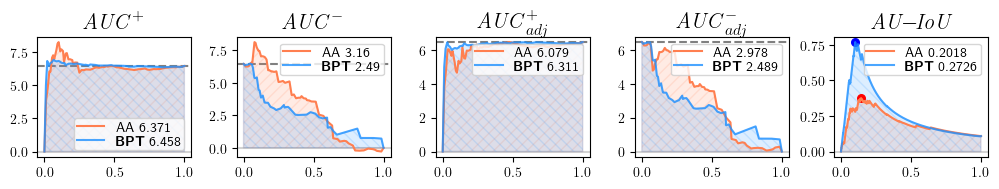

In [45]:
fig,axes = plt.subplots(1,5, figsize=(10,2), sharex=True)#, sharey=True) #3,3  figsize=(8,2.2)

for i in range(5):
    ax = axes.flat[i]
    if i==0: # insertion/regression
        title='$\\mathit{AUC}^{+}$'
        Xa,Ya,Ma,La = aucI_aa['xs'], aucI_aa['ys'], aucI_aa['ms'], aucI_aa['auc']
        Xb,Yb,Mb,Lb = aucI_bpt['xs'], aucI_bpt['ys'], aucI_bpt['ms'], aucI_bpt['auc']
        # Xa,Ya,Ma,La = aucI_aa[0], aucI_aa[1], aucI_aa[2], aucI_aa[3]
        # Xb,Yb,Mb,Lb = aucI_bpt[0], aucI_bpt[1], aucI_bpt[2], aucI_bpt[3]
    elif i==1: # deletion/regression
        title='$\\mathit{AUC}^{-}$'
        Xa,Ya,Ma,La = aucD_aa['xs'], aucD_aa['ys'], aucD_aa['ms'], aucD_aa['auc']
        Xb,Yb,Mb,Lb = aucD_bpt['xs'], aucD_bpt['ys'], aucD_bpt['ms'], aucD_bpt['auc']
        # Xa,Ya,Ma,La = aucD_aa[0], aucD_aa[1], aucD_aa[2], aucD_aa[3]
        # Xb,Yb,Mb,Lb = aucD_bpt[0], aucD_bpt[1], aucD_bpt[2], aucD_bpt[3]
    elif i==2: # AUC+adj
        title='$\\mathit{AUC}^{+}_{adj}$'
        Xa,Ya,Ma,La = aucI_aa['xs'], aucI_aa['y_adj'], aucI_aa['ms'], aucI_aa['auc_adj']
        Xb,Yb,Mb,Lb = aucI_bpt['xs'], aucI_bpt['y_adj'], aucI_bpt['ms'], aucI_bpt['auc_adj']
    elif i==3: # AUC-adj
        title='$\\mathit{AUC}^{-}_{adj}$'
        Xa,Ya,Ma,La = aucD_aa['xs'], aucD_aa['y_adj'], aucD_aa['ms'], aucD_aa['auc_adj']
        Xb,Yb,Mb,Lb = aucD_bpt['xs'], aucD_bpt['y_adj'], aucD_bpt['ms'], aucD_bpt['auc_adj']
    # elif i==2: # insertion/error
    #     title='$\\mathit{MSE}^{+}$'
    #     Xa,Ya,Ma,La = aucI_aa[0], (aucI_aa[1]-aucI_aa[2])**2, aucI_aa[2], aucI_aa[5]
    #     Xb,Yb,Mb,Lb = aucI_bpt[0], (aucI_bpt[1]-aucI_bpt[2])**2, aucI_bpt[2], aucI_bpt[5]
    # elif i==3: # deletion/error
    #     title='$\\mathit{MSE}^{-}$'
    #     Xa,Ya,Ma,La = aucD_aa[0], (aucD_aa[1]-aucD_aa[2])**2, aucD_aa[2], aucD_aa[5]
    #     Xb,Yb,Mb,Lb = aucD_bpt[0], (aucD_bpt[1]-aucD_bpt[2])**2, aucD_bpt[2], aucD_bpt[5]
    elif i==4: # IoU
        title='$\\mathit{AU}{\\!-\\!}\\mathit{IoU}$'
        # return X2, IoU2, Th[best_pt], X2[best_pt], auc_IoU
        Xa,Ya,Ma,La = auc_IoU_aa['X'], auc_IoU_aa['Y'], None, auc_IoU_aa['auc_IoU']
        Xb,Yb,Mb,Lb = auc_IoU_bpt['X'], auc_IoU_bpt['Y'], None, auc_IoU_bpt['auc_IoU']
        xma, yma = auc_IoU_aa['x_best'], np.max(auc_IoU_aa['Y'])
        xmb, ymb = auc_IoU_bpt['x_best'], np.max(auc_IoU_bpt['Y'])
        # Xa,Ya,Ma,La = auc_IoU_aa[0], auc_IoU_aa[1], None, auc_IoU_aa[4]
        # Xb,Yb,Mb,Lb = auc_IoU_bpt[0], auc_IoU_bpt[1], None, auc_IoU_bpt[4]
        # xma, yma = auc_IoU_aa[3], np.max(auc_IoU_aa[1])
        # xmb, ymb = auc_IoU_bpt[3], np.max(auc_IoU_bpt[1])

    Sa, Sb = ('\\textbf', '') if La<Lb else ('', '\\textbf')
    if i in [0,2,4]:   Sa,Sb=Sb,Sa
    ax.plot(Xa, Ya, c='coral', label=f'{Sa}{{AA}} {La:.4}')
    ax.fill_between(Xa, Ya, color='coral', alpha=0.15, hatch='///')
    # ax.scatter(Xa, Ya, c='black', s=5)
    ax.plot(Xb, Yb, c='dodgerblue', label=f'{Sb}{{BPT}} {Lb:.4}', alpha=0.80)
    ax.fill_between(Xb, Yb, color='dodgerblue', alpha=0.15, hatch='\\\\\\')
    
    if i==4: # IoU
        ax.scatter(xma, yma, s=30, color='red')
        ax.scatter(xmb, ymb, s=30, color='blue')
    else:
        ax.axhline(abs(f_S-f_0), ls='--', c='grey', zorder=0)
    
    ax.axhline(0, c='lightgrey', zorder=0)
    ax.legend(borderpad=0.2, labelspacing=0.1, loc='upper right' if i>=1 else 'lower right')#, bbox_to_anchor=(1,0))
    ax.set_title(title, fontsize=16)

plt.tight_layout()
# plt.savefig(f'paper_figures/figure_2_B_five_metrics.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
print(f'f(0)={f_0}  f(S)={f_S}  delta={f_S-f_0}')
plt.show()

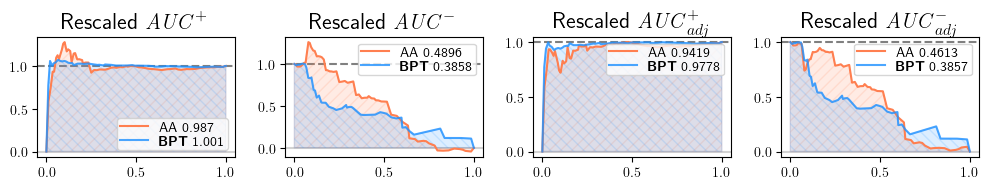

In [46]:
fig,axes = plt.subplots(1,4, figsize=(10,2), sharex=True)#, sharey=True) #3,3  figsize=(8,2.2)

for i in range(4):
    ax = axes.flat[i]
    if i==0: # insertion/regression
        title='Rescaled $\\mathit{AUC}^{+}$'
        Xa,Ya,Ma,La = aucI_aa['xs'], aucI_aa['ysr'], aucI_aa['ms'], aucI_aa['auc_r']
        Xb,Yb,Mb,Lb = aucI_bpt['xs'], aucI_bpt['ysr'], aucI_bpt['ms'], aucI_bpt['auc_r']
    elif i==1: # deletion/regression
        title='Rescaled $\\mathit{AUC}^{-}$'
        Xa,Ya,Ma,La = aucD_aa['xs'], aucD_aa['ysr'], aucD_aa['ms'], aucD_aa['auc_r']
        Xb,Yb,Mb,Lb = aucD_bpt['xs'], aucD_bpt['ysr'], aucD_bpt['ms'], aucD_bpt['auc_r']
    elif i==2: # AUC+adj
        title='Rescaled $\\mathit{AUC}^{+}_{adj}$'
        Xa,Ya,Ma,La = aucI_aa['xs'], aucI_aa['y_adjr'], aucI_aa['ms'], aucI_aa['auc_adjr']
        Xb,Yb,Mb,Lb = aucI_bpt['xs'], aucI_bpt['y_adjr'], aucI_bpt['ms'], aucI_bpt['auc_adjr']
    elif i==3: # AUC-adj
        title='Rescaled $\\mathit{AUC}^{-}_{adj}$'
        Xa,Ya,Ma,La = aucD_aa['xs'], aucD_aa['y_adjr'], aucD_aa['ms'], aucD_aa['auc_adjr']
        Xb,Yb,Mb,Lb = aucD_bpt['xs'], aucD_bpt['y_adjr'], aucD_bpt['ms'], aucD_bpt['auc_adjr']

    Sa, Sb = ('\\textbf', '') if La<Lb else ('', '\\textbf')
    if i in [0,2]:   Sa,Sb=Sb,Sa
    ax.plot(Xa, Ya, c='coral', label=f'{Sa}{{AA}} {La:.4}')
    ax.fill_between(Xa, Ya, color='coral', alpha=0.15, hatch='///')
    # ax.scatter(Xa, Ya, c='black', s=5)
    ax.plot(Xb, Yb, c='dodgerblue', label=f'{Sb}{{BPT}} {Lb:.4}', alpha=0.80)
    ax.fill_between(Xb, Yb, color='dodgerblue', alpha=0.15, hatch='\\\\\\')
    
    ax.axhline(1.0, ls='--', c='grey', zorder=0)
    
    ax.axhline(0, c='lightgrey', zorder=0)
    ax.legend(borderpad=0.2, labelspacing=0.1, loc='upper right' if i>=1 else 'lower right')#, bbox_to_anchor=(1,0))
    ax.set_title(title, fontsize=16)

plt.tight_layout()
# plt.savefig(f'paper_figures/figure_2_B_five_metrics.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

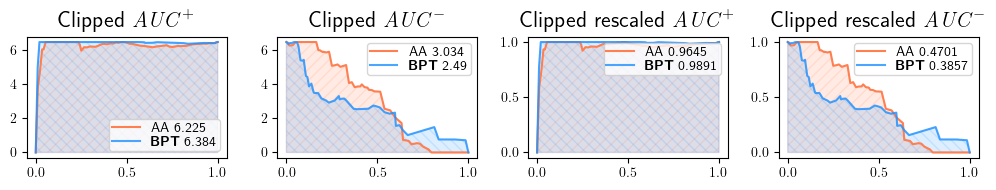

In [47]:
fig,axes = plt.subplots(1,4, figsize=(10,2), sharex=True)#, sharey=True) #3,3  figsize=(8,2.2)

for i in range(4):
    ax = axes.flat[i]
    if i==0: # clipped insertion
        title='Clipped $\\mathit{AUC}^{+}$'
        Xa,Ya,Ma,La = aucI_aa['xs'], aucI_aa['y_clip'], aucI_aa['ms'], aucI_aa['auc_clip']
        Xb,Yb,Mb,Lb = aucI_bpt['xs'], aucI_bpt['y_clip'], aucI_bpt['ms'], aucI_bpt['auc_clip']
    elif i==1: # clipped deletion
        title='Clipped $\\mathit{AUC}^{-}$'
        Xa,Ya,Ma,La = aucD_aa['xs'], aucD_aa['y_clip'], aucD_aa['ms'], aucD_aa['auc_clip']
        Xb,Yb,Mb,Lb = aucD_bpt['xs'], aucD_bpt['y_clip'], aucD_bpt['ms'], aucD_bpt['auc_clip']
    elif i==2: # clipped rescaled insertion
        title='Clipped rescaled $\\mathit{AUC}^{+}$'
        Xa,Ya,Ma,La = aucI_aa['xs'], aucI_aa['y_clipr'], aucI_aa['ms'], aucI_aa['auc_clipr']
        Xb,Yb,Mb,Lb = aucI_bpt['xs'], aucI_bpt['y_clipr'], aucI_bpt['ms'], aucI_bpt['auc_clipr']
    elif i==3: # clipped rescaled deletion
        title='Clipped rescaled $\\mathit{AUC}^{-}$'
        Xa,Ya,Ma,La = aucD_aa['xs'], aucD_aa['y_clipr'], aucD_aa['ms'], aucD_aa['auc_clipr']
        Xb,Yb,Mb,Lb = aucD_bpt['xs'], aucD_bpt['y_clipr'], aucD_bpt['ms'], aucD_bpt['auc_clipr']

    Sa, Sb = ('\\textbf', '') if La<Lb else ('', '\\textbf')
    if i in [0,2]:   Sa,Sb=Sb,Sa
    ax.plot(Xa, Ya, c='coral', label=f'{Sa}{{AA}} {La:.4}')
    ax.fill_between(Xa, Ya, color='coral', alpha=0.15, hatch='///')
    # ax.scatter(Xa, Ya, c='black', s=5)
    ax.plot(Xb, Yb, c='dodgerblue', label=f'{Sb}{{BPT}} {Lb:.4}', alpha=0.80)
    ax.fill_between(Xb, Yb, color='dodgerblue', alpha=0.15, hatch='\\\\\\')
    
    # ax.axhline(1.0, ls='--', c='grey', zorder=0)    
    # ax.axhline(0, c='lightgrey', zorder=0)
    ax.legend(borderpad=0.2, labelspacing=0.1, loc='upper right' if i>=1 else 'lower right')#, bbox_to_anchor=(1,0))
    ax.set_title(title, fontsize=16)

plt.tight_layout()
# plt.savefig(f'paper_figures/figure_2_B_five_metrics.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

## save plots as independent pictures

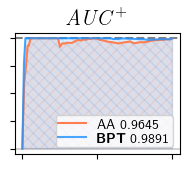

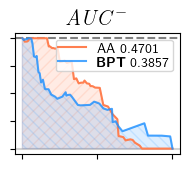

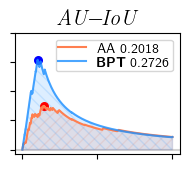

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex=True, sharey=True)

# titles = [
#     '$\\mathit{AUC}^{+}$',
#     '$\\mathit{AUC}^{-}$',
#     # '$\\mathit{MSE}^{+}$',
#     # '$\\mathit{MSE}^{-}$',
#     '$\\mathit{AU}{\!-\!}\\mathit{IoU}$'
# ]

for i in range(3):
    fig, ax = plt.subplots(figsize=(2,1.8 ))  # Adjust figure size as needed

    if i == 0:  # insertion/regression
        title='$\\mathit{AUC}^{+}$'
        higher_better = True
        Xa,Ya,Ma,La = aucI_aa['xs'], aucI_aa['y_clipr'], aucI_aa['ms'], aucI_aa['auc_clipr']
        Xb,Yb,Mb,Lb = aucI_bpt['xs'], aucI_bpt['y_clipr'], aucI_bpt['ms'], aucI_bpt['auc_clipr']
    elif i == 1:  # deletion/regression
        title='$\\mathit{AUC}^{-}$'
        higher_better = False
        Xa,Ya,Ma,La = aucD_aa['xs'], aucD_aa['y_clipr'], aucD_aa['ms'], aucD_aa['auc_clipr']
        Xb,Yb,Mb,Lb = aucD_bpt['xs'], aucD_bpt['y_clipr'], aucD_bpt['ms'], aucD_bpt['auc_clipr']
    # elif i == 2:  # insertion/error
    #     Xa, Ya, Ma, La = aucI_aa[0], (aucI_aa[1] - aucI_aa[2]) ** 2, aucI_aa[2], aucI_aa[5]
    #     Xb, Yb, Mb, Lb = aucI_bpt[0], (aucI_bpt[1] - aucI_bpt[2]) ** 2, aucI_bpt[2], aucI_bpt[5]
    # elif i == 3:  # deletion/error
    #     Xa, Ya, Ma, La = aucD_aa[0], (aucD_aa[1] - aucD_aa[2]) ** 2, aucD_aa[2], aucD_aa[5]
    #     Xb, Yb, Mb, Lb = aucD_bpt[0], (aucD_bpt[1] - aucD_bpt[2]) ** 2, aucD_bpt[2], aucD_bpt[5]
    elif i == 2:  # IoU
        title = '$\\mathit{AU}{\\!-\\!}\\mathit{IoU}$'
        higher_better = True
        Xa,Ya,Ma,La = auc_IoU_aa['X'], auc_IoU_aa['Y'], None, auc_IoU_aa['auc_IoU']
        Xb,Yb,Mb,Lb = auc_IoU_bpt['X'], auc_IoU_bpt['Y'], None, auc_IoU_bpt['auc_IoU']
        xma, yma = auc_IoU_aa['x_best'], np.max(auc_IoU_aa['Y'])
        xmb, ymb = auc_IoU_bpt['x_best'], np.max(auc_IoU_bpt['Y'])

    Sa, Sb = ('\\textbf', '') if La < Lb else ('', '\\textbf')
    if higher_better:
        Sa, Sb = Sb, Sa

    ax.plot(Xa, Ya, c='coral', label=f'{Sa}{{AA}} {La:.4}')
    ax.fill_between(Xa, Ya, color='coral', alpha=0.15, hatch='///')
    ax.plot(Xb, Yb, c='dodgerblue', label=f'{Sb}{{BPT}} {Lb:.4}', alpha=0.80)
    ax.fill_between(Xb, Yb, color='dodgerblue', alpha=0.15, hatch='\\\\\\')

    if i == 2:
        ax.scatter(xma, yma, s=30, color='red')
        ax.scatter(xmb, ymb, s=30, color='blue')
    if i < 2:
        ax.axhline(1, ls='--', c='grey', zorder=0)

    ax.axhline(0, c='lightgrey', zorder=0)
    ax.legend(borderpad=0.2, labelspacing=0.1, loc='upper right' if i >= 1 else 'lower right')
    ax.set_title(title, fontsize=16)
    ax.set_yticks([0.0,0.25,0.5,0.75,1.0])
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.tight_layout()
    plt.savefig(f'paper_figures/figure_2_B_metric_{i+1}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
    plt.show()

# Visualize the coalitions 

In [49]:
from skimage.segmentation import mark_boundaries

In [50]:
%%time
bptree = shap_bpt.build_bpt_from_image(image_to_explain)

CPU times: total: 156 ms
Wall time: 157 ms


In [51]:
def colorize(nodes, img, i):
    is_aa = isinstance(nodes[0], shap_bpt.AxisAlignedSegment)
    pxflat_image = image_to_explain.reshape((img.shape[0] * img.shape[1], 3))
    colored = np.zeros_like(image_to_explain, dtype=np.float32)
    flat_colored = colored.reshape(pxflat_image.shape)
    for node in nodes:
        if is_aa:
            clr = np.mean(np.mean(image_to_explain[node.ymin:node.ymax, node.xmin:node.xmax, :], axis=1), axis=0)/255.0
            colored[ node.ymin:node.ymax, node.xmin:node.xmax ] = clr
        else:
            s,e = node.pixels_interval()
            clr = np.mean(pxflat_image[ node.bpt.pixels[s:e] ], axis=0)/255.0
            flat_colored[ node.bpt.pixels[s:e], :: ] = clr #np.array(cmap[s % len(cmap)])[0:3]
    return colored

def make_segments(nodes, img):
    is_aa = isinstance(nodes[0], shap_bpt.AxisAlignedSegment)
    flat_img = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint32)
    for i, node in enumerate(nodes):
        if is_aa:
            flat_img[ node.ymin:node.ymax, node.xmin:node.xmax ] = i
        else:
            s,e = node.pixels_interval()
            flat_img.ravel()[ node.bpt.pixels[s:e] ] = i
    return flat_img#.reshape((img.shape[0], img.shape[1]))

## FIGURE 1:C(AA)

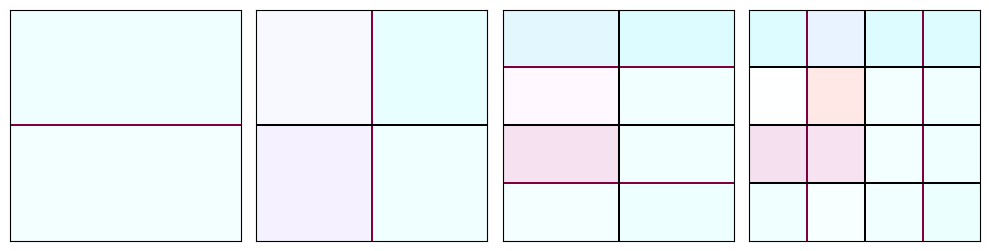

In [52]:
base_segment = shap_bpt.BaseSegment()
root_node, name = shap_bpt.AxisAlignedSegment(0, bptree.width, 0, bptree.height, base_segment), 'AA'
#root_node, name = shap_bpt.BPT_Segment(bptree, bptree.N-1, base_segment), 'BPT'
segments = [root_node]
all_nodes = [root_node]
prev_boundaries = None

def expand_tree(segments, all_nodes):
    new_segments = []
    for s in segments:
        split = s.split(s, s)
        if split is None:
            new_segments.append(s)
            leaves[ii] += 1
        else:
            new_segments.extend(split)
            all_nodes.extend(split)
    return new_segments

K=4
leaves = np.zeros(K, dtype=int)
fig, axes = plt.subplots(1,(K), figsize=(10,4))
for ii in range(0,K+1):
    img = colorize(segments, image_to_explain, 0)
    img = np.clip(0.2 + img * 1.1, 0, 1)
    sgm = make_segments(segments, image_to_explain)
    cut_color = (.5, 0, .25, 1)
    boundaries = mark_boundaries(np.tile((255,255,255,0), (image_to_explain.shape[0],image_to_explain.shape[1],1)), sgm, 
                                 mode='thick', color=cut_color)
    
    if ii>=1:# and ii%2==0:
        ax = axes.flatten()[(ii)-1]
        ax.set_xticks([]) ; ax.set_yticks([])
        ax.imshow(img)#, alpha=0.75)
        ax.imshow(boundaries)
        nshape = (224*224, 4)
        boundaries.reshape(nshape)[ np.where(boundaries.reshape(nshape) == cut_color)[0] ] = (0,0,0,1)
        if prev_boundaries is not None:
            ax.imshow(prev_boundaries)
#         ax.set_title(f'depth={ii}, $n$={len(segments)}', fontsize=20)

    prev_boundaries = boundaries
    segments = expand_tree(segments, all_nodes)

plt.tight_layout()
plt.savefig(f'paper_figures/figure1_C_{name}_expansion.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

## FIGURE 1:C(BPT)

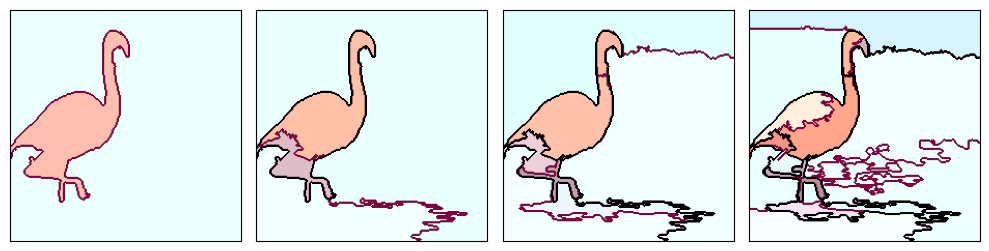

In [53]:
base_segment = shap_bpt.BaseSegment()
# root_node, name = shap_bpt.AxisAlignedSegment(0, bptree.width, 0, bptree.height, base_segment), 'AA'
root_node, name = shap_bpt.BPT_Segment(bptree, bptree.N-1, base_segment), 'BPT'
segments = [root_node]
all_nodes = [root_node]
prev_boundaries = None

def expand_tree(segments, all_nodes):
    new_segments = []
    for s in segments:
        split = s.split(s, s)
        if split is None:
            new_segments.append(s)
            leaves[ii] += 1
        else:
            new_segments.extend(split)
            all_nodes.extend(split)
    return new_segments

K=4
leaves = np.zeros(K, dtype=int)
fig, axes = plt.subplots(1,(K), figsize=(10,4))
for ii in range(0,K+1):
    img = colorize(segments, image_to_explain, 0)
    img = np.clip(0.2 + img * 1.1, 0, 1)
    sgm = make_segments(segments, image_to_explain)
    cut_color = (.5, 0, .25, 1)
    boundaries = mark_boundaries(np.tile((255,255,255,0), (image_to_explain.shape[0],image_to_explain.shape[1],1)), sgm, 
                                 mode='thick', color=cut_color)
    
    if ii>=1:# and ii%2==0:
        ax = axes.flatten()[(ii)-1]
        ax.set_xticks([]) ; ax.set_yticks([])
        ax.imshow(img)#, alpha=0.75)
        ax.imshow(boundaries)
        nshape = (224*224, 4)
        boundaries.reshape(nshape)[ np.where(boundaries.reshape(nshape) == cut_color)[0] ] = (0,0,0,1)
        if prev_boundaries is not None:
            ax.imshow(prev_boundaries)
#         ax.set_title(f'depth={ii}, $n$={len(segments)}', fontsize=20)

    prev_boundaries = boundaries
    segments = expand_tree(segments, all_nodes)

plt.tight_layout()
plt.savefig(f'paper_figures/figure1_C_{name}_expansion.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

# Recursive patches

In [54]:
importlib.reload(shap_bpt)
def empty_nu(img):
    return np.zeros((3,1))
explainer = shap_bpt.Explainer(empty_nu, image_to_explain, num_explained_classes=3, verbose=False)

targets = []
def enum_targets(aa, depth):
    if depth==0:
        targets.append(aa)
    else:
        aa1, aa2 = aa.split(None, None)
        enum_targets(aa1, depth-1)
        enum_targets(aa2, depth-1)

In [55]:
s0 = shap_bpt.BPT_Segment(bptree, bptree.N-1, None) ; 
enum_targets(s0, 4)

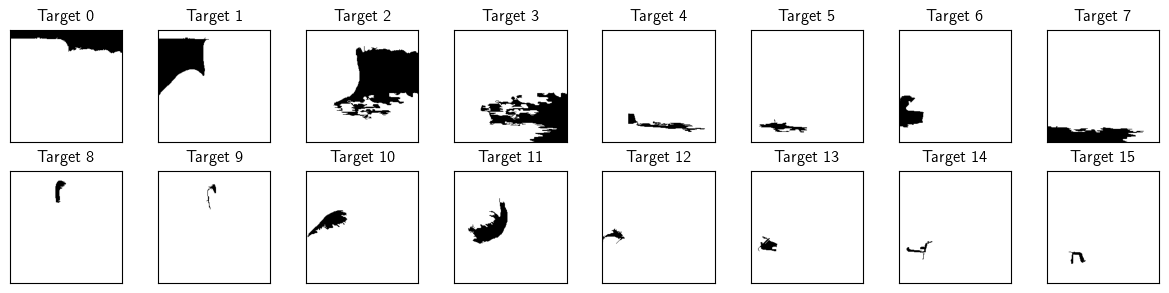

In [56]:
nr, nc = 2, 8
fig, axes = plt.subplots(nr, nc, figsize=(nc*1.5, nr*1.5))
for i in range(nr * nc):
    ax = axes[i // nc, i % nc]
    mask = np.zeros(image_to_explain.shape[:2], dtype=np.uint8)
    targets[i].fill_mask(mask, False)
    ax.imshow(~mask, cmap='gray')
    ax.set_title(f'Target {i}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [57]:
coal_num = 8 ; coal_t='bpt'
# coal_num = 10 ; coal_t='bpt'

In [58]:
list_of_patches = None
def Phi(S, T):
    global explainer, list_of_patches
    for Ci in S:
        if Ci.equals(T):
            mask = explainer.empty_mask()
            patch_num = 1
            for C in S:
                if not C.equals(T):
                    C.fill_mask(mask, False)
            vS = explainer.predict_masked([mask])
            if list_of_patches is not None:
                list_of_patches.append((mask, Ci))
            Ci.fill_mask(mask, False)
            return
        elif Ci.contains(T):
            Si = [Cj for Cj in S if not Cj.equals(Ci)]
            Ci1, Ci2 = Ci.split(None, None)
            if Ci2.contains(T):
                Ci1, Ci2 = Ci2, Ci1
                
            Phi(Si + [Ci1], T)
            Phi(Si + [Ci1, Ci2], T)
            return
    assert False

In [59]:
def get_list_of_patches(S, T):
    global list_of_patches
    list_of_patches = []
    Phi(S, T)
    l, list_of_patches = list_of_patches, None
    return l

lp = get_list_of_patches([s0], targets[coal_num])
print(len(targets), len(lp))

16 16


### Figure 1 : D (BPT)

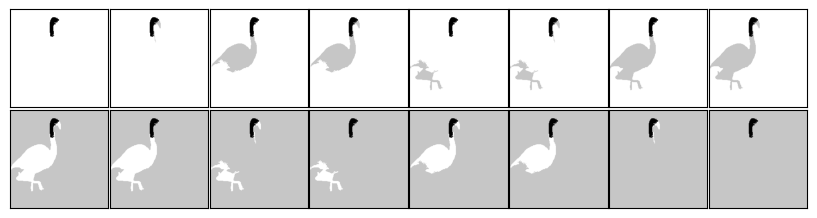

In [60]:
nr, nc = len(lp)//8, 8
fig,axes = plt.subplots(nr, nc, figsize=(nc, 1.05*nr))
for i, (mask,C) in enumerate(lp):
    ax = axes.ravel()[i]
    ax.imshow(mask, cmap='Greys', vmin=0, vmax=3)
    C.plot(ax, color=(0,0,0,1.0))
    ax.set_xticks([]) ; ax.set_yticks([])
plt.tight_layout(pad=0.1)
plt.savefig(f'paper_figures/figure1_D_coalitions_{coal_t}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

### Figure 1 : D (AA)

In [61]:
importlib.reload(shap_bpt)
def empty_nu(img):
    return np.zeros((3,1))
explainer = shap_bpt.Explainer(empty_nu, image_to_explain, num_explained_classes=3, verbose=False)

targets = []
def enum_targets(aa, depth):
    if depth==0:
        targets.append(aa)
    else:
        aa1, aa2 = aa.split(None, None)
        enum_targets(aa1, depth-1)
        enum_targets(aa2, depth-1)

In [62]:
s0 = shap_bpt.AxisAlignedSegment(0, image_to_explain.shape[0], 0,image_to_explain.shape[1], None) ; 
enum_targets(s0, 4)

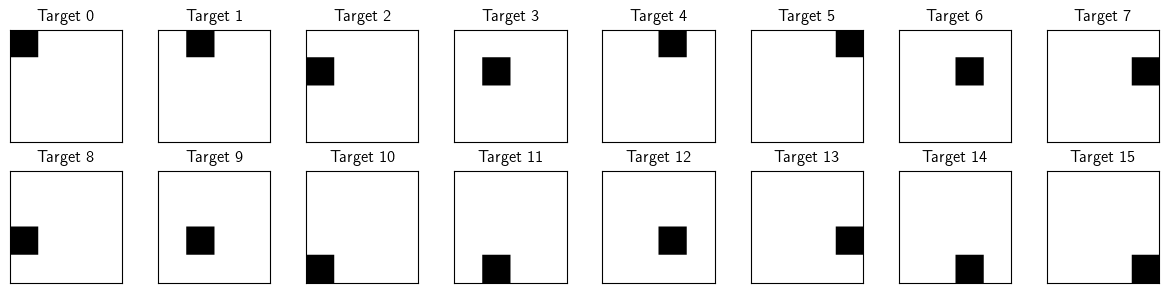

In [63]:
nr, nc = 2, 8
fig, axes = plt.subplots(nr, nc, figsize=(nc*1.5, nr*1.5))
for i in range(nr * nc):
    ax = axes[i // nc, i % nc]
    mask = np.zeros(image_to_explain.shape[:2], dtype=np.uint8)
    targets[i].fill_mask(mask, False)
    ax.imshow(~mask, cmap='gray')
    ax.set_title(f'Target {i}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [64]:
coal_num = 8 ; coal_t='aa'
# coal_num = 6 ; coal_t='aa'

In [65]:
list_of_patches = None
def Phi(S, T):
    global explainer, list_of_patches
    for Ci in S:
        if Ci.equals(T):
            mask = explainer.empty_mask()
            patch_num = 1
            for C in S:
                if not C.equals(T):
                    C.fill_mask(mask, False)
            vS = explainer.predict_masked([mask])
            if list_of_patches is not None:
                list_of_patches.append((mask, Ci))
            Ci.fill_mask(mask, False)
            return
        elif Ci.contains(T):
            Si = [Cj for Cj in S if not Cj.equals(Ci)]
            Ci1, Ci2 = Ci.split(None, None)
            if Ci2.contains(T):
                Ci1, Ci2 = Ci2, Ci1
                
            Phi(Si + [Ci1], T)
            Phi(Si + [Ci1, Ci2], T)
            return
    assert False

In [66]:
lp = get_list_of_patches([s0], targets[coal_num])
print(len(targets), len(lp))

16 16


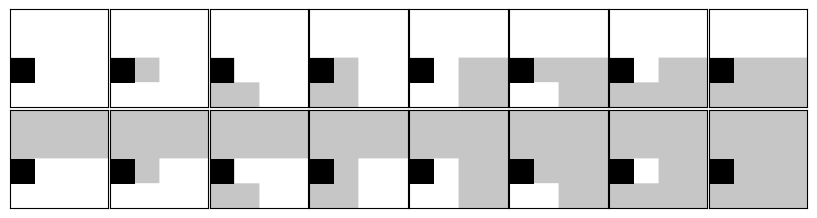

In [67]:
nr, nc = len(lp)//8, 8
fig,axes = plt.subplots(nr, nc, figsize=(nc, 1.05*nr))
for i, (mask,C) in enumerate(lp):
    ax = axes.ravel()[i]
    ax.imshow(mask, cmap='Greys', vmin=0, vmax=3)
    C.plot(ax, color=(0,0,0,1.0))
    ax.set_xticks([]) ; ax.set_yticks([])
plt.tight_layout(pad=0.1)
plt.savefig(f'paper_figures/figure1_D_coalitions_{coal_t}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

# Ground truth visualization

In [68]:
def vis_IoU(shapley_values, threshold, ground_truth):
    pred = shapley_values.flatten() >= threshold
    real = ground_truth.flatten()
    image = np.full((len(pred), 3), 255, dtype=np.float32)

    image[ pred & real, : ]    = (0.0, 0.0, 0.75) # True Positives
    image[ pred & (~real), : ] = (1.0, 0.6, 0.2) # False Positives
    image[ (~pred) & real, : ] = (1.0, 0.4, 1.0) # False Negatives

    return image.reshape(list(ground_truth.shape) + [3])

### Figure 3: C (GT)

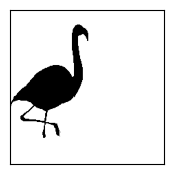

In [69]:
plt.figure(figsize=(2,2))
plt.imshow(ground_truth, cmap='Greys')
plt.xticks([]) ; plt.yticks([])
plt.savefig(f'paper_figures/figure_2_C_IoU_.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

In [70]:
auc_IoU_aa

{'X': array([0.00000000e+00, 1.99298469e-05, 3.98596939e-05, ...,
        9.99940210e-01, 9.99960140e-01, 9.99980070e-01]),
 'Y': array([0.00018413, 0.00036826, 0.00055238, ..., 0.1082654 , 0.10826324,
        0.10826109]),
 'max_IoU_heatmap_threshold': 0.00025955437354705473,
 'max_IoU_score': 0.37281553398058254,
 'x_best': 0.14536830357142858,
 'auc_IoU': 0.20176671553217046}

### Figure 3: C (AA)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


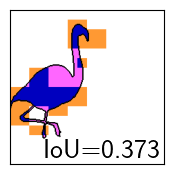

In [71]:
img, max_IoU, name = vis_IoU(shapley_values_aa, auc_IoU_aa['max_IoU_heatmap_threshold'], ground_truth), np.max(auc_IoU_aa['Y']), 'AA'
# img, max_IoU, name = vis_IoU(shapley_values_bpt, auc_IoU_bpt[2], ground_truth), np.max(auc_IoU_bpt[1]), 'BPT'
plt.figure(figsize=(2,2))
plt.imshow(img)

marked_h = mark_boundaries(np.tile((255,255,255,0), (img.shape[0],img.shape[1],1)), ground_truth, 
                             mode='thick', color=(0,0,0,1))
plt.imshow(marked_h)

plt.text(50,215, f'IoU={max_IoU:.3}', fontsize=20)
plt.xticks([]) ; plt.yticks([])
plt.savefig(f'paper_figures/figure_2_C_IoU_{name}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
# plt.savefig(f'IoU_BPT_{name}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

### Figure 3: C (BPT)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


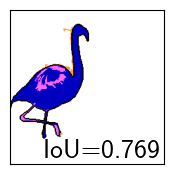

In [72]:
# img, max_IoU, name = vis_IoU(shapley_values_aa, auc_IoU_aa[2], ground_truth), np.max(auc_IoU_aa[1]), 'AA'
img, max_IoU, name = vis_IoU(shapley_values_bpt, auc_IoU_bpt['max_IoU_heatmap_threshold'], ground_truth), np.max(auc_IoU_bpt['Y']), 'BPT'
plt.figure(figsize=(2,2))
plt.imshow(img)
marked_h = mark_boundaries(np.tile((255,255,255,0), (img.shape[0],img.shape[1],1)), ground_truth, 
                             mode='thick', color=(0,0,0,1))
plt.imshow(marked_h)
plt.text(50,215, f'IoU={max_IoU:.3}', fontsize=20)
plt.xticks([]) ; plt.yticks([])
plt.savefig(f'paper_figures/figure_2_C_IoU_{name}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

## END